# <center> <u> Copula </u> </center>

In [1]:
import numpy as np
import pandas as pd 

from numba import jit, prange
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

## <center> Set Seaborn Plot Theme </center> 

In [2]:
sns.set_theme(
    context = "notebook",
    style = "darkgrid", 
    palette = "pastel",
)

sns.set(rc = {'figure.figsize':(10, 5)})

## <center> Cholesky Decomposition </center> 

In [3]:
@jit(nopython = True, parallel = True)
def compute_cholesky_decomposition(p):
    """
    
    """
    
    N = 10000
    x1 = np.zeros(N)
    x2 = np.zeros(N)
    
    z1 = np.random.normal(0, 1, N)
    z2 = np.random.normal(0, 1, N)
    
    x1 = z1
    
    for i in prange(N):
        x2[i] = p * z1[i] + np.sqrt(1 - p**2) * z2[i]
    
    
    return x1, x2

In [4]:
x, y = compute_cholesky_decomposition(p = 0.8)

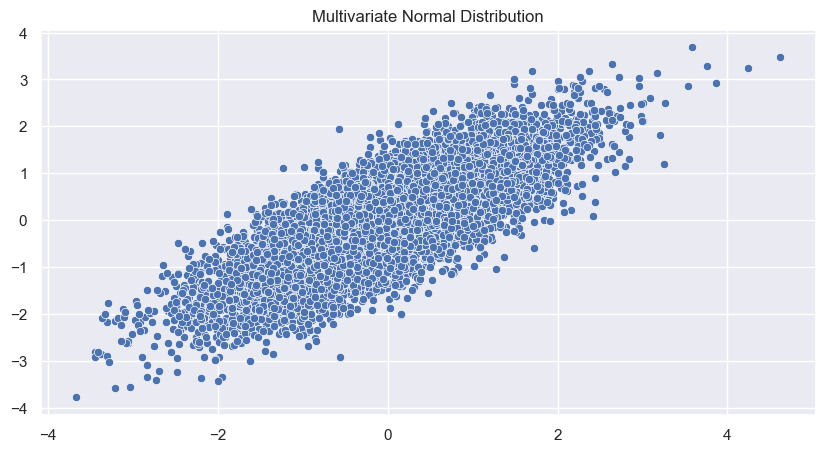

In [5]:
ax = sns.scatterplot(
    x = x,
    y = y,
)

ax.set(
    title = "Multivariate Normal Distribution"
)

plt.show()

## <center> Probability Density Function </center> 

In [6]:
@jit(nopython = True)
def gaussian_distribution(x):
    
    mu = 0
    sigma = 1
    
    z = ((x - mu) / sigma)**2
    
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * z)

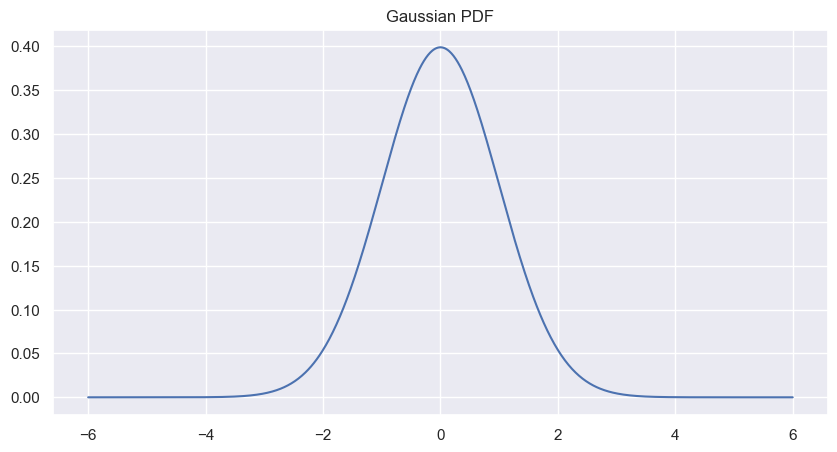

In [7]:
X = np.linspace(-6, 6, 1000)
pdf = gaussian_distribution(X)

ax = sns.lineplot(
    x = X, 
    y = pdf,
)

ax.set(
    title = "Gaussian PDF"
)

plt.show()

## <center> Cumulative Distribution Function </center> 

In [8]:
@jit(nopython = True)
def trapezoid_rule(pdf, X):
    """
    
    """
    
    area = 0
    integral = np.copy(pdf)
    
    for i in range(1, len(pdf)):
        area += (X[i] - X[i-1]) * 1/2 * (pdf[i] + pdf[i - 1])
        integral[i] = area
                   
    return integral

In [9]:
@jit(nopython = True)
def simpsons_rule(pdf, X):
    """
    
    """
    
    area = 0
    integral = np.copy(pdf)
    
    for i in range(1, len(pdf)):
        area += (X[i] - X[i-1]) / 6 * (pdf[i] + 4 * ((pdf[i] + pdf[i-1]) / 2) + pdf[i-1])
        integral[i] = area
    
    return integral

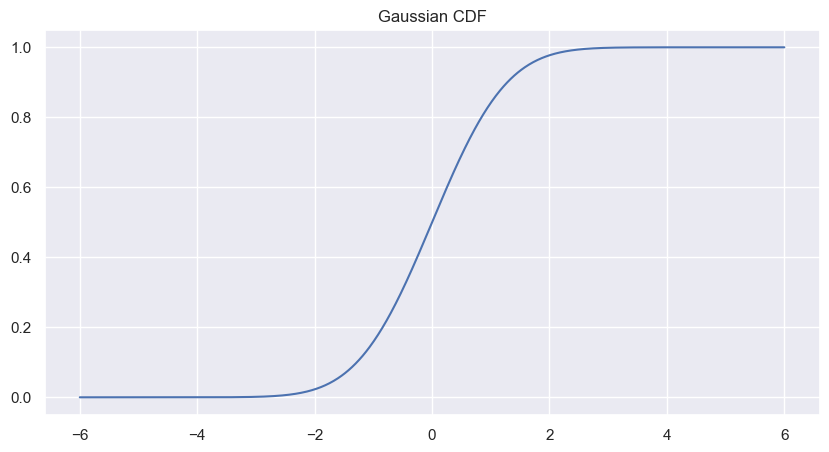

In [10]:
cdf = simpsons_rule(pdf, X)

ax = sns.lineplot(
    x = X, 
    y = cdf,
)

ax.set(
    title = "Gaussian CDF"
)

plt.show()

## <center> Bisection Method for CDF Inverse </center> 

In [11]:
@jit(nopython = True)
def bisection_method(func, integral):
    """
    Input: 
    - Probability Density Function 
    
    Output:
    - Inverse Value from CDF
    """
    
    a = 0
    b = 1
    c = (a + b) / 2
    
    err_tol = 1e-5
    max_itr = 1000
    
    N = 1000
    interval = np.linspace(0, c, N)
    func_c = np.zeros(N)
    
    for i in range(N):
        func_c[i] = func(interval[i])  
        
    c_cdf = simpsons_rule(func_c, interval)[-1]

    itr_count = 0
    while np.abs(c_cdf - integral) > err_tol and itr_count < max_itr:
    
        if c_cdf < integral:
            a = c
            c = (a + b) / 2
            
        if c_cdf > integral: 
            b = c
            c = (a + b) / 2

        interval = np.linspace(0, c, N)
        func_c = np.zeros(N)
        
        for i in range(len(interval)):
            func_c[i] = func(interval[i])
            
        c_cdf = simpsons_rule(func_c, interval)[-1]
    
        itr_count += 1
        
    if itr_count >= max_itr:
        print("Max Iteration Count")
        return 0
    
    return c

In [12]:
@jit(nopython = True)
def compute_inverse(func, integral):
    """
    Wrapper Method that Call Custom Bisection Method for Inverse CDF
    """
    
    root = bisection_method(func, integral)
    
    return root

## <center> Inverse Cumulative Distribution Function </center> 

In [13]:
@jit(nopython = True)
def compute_inverse_cdf(integral):
    """
    Input: 
    - Probability Density Function 
    
    Output:
    - Inverse Value from CDF
    """
    
    a = -6
    b = 6
    c = (a + b) / 2
    
    err_tol = 1e-5
    max_itr = 1000
            
    N = 1000
    interval = np.linspace(-6, c, N)
    func_c = np.zeros(N)
    
    for i in range(N):
        func_c[i] = gaussian_distribution(interval[i])  
        
    c_cdf = simpsons_rule(func_c, interval)[-1]

    itr_count = 0
    while np.abs(c_cdf - integral) > err_tol and itr_count < max_itr:
    
        if c_cdf < integral:
            a = c
            c = (a + b) / 2
            
        if c_cdf > integral: 
            b = c
            c = (a + b) / 2

        interval = np.linspace(-6, c, N)
        func_c = np.zeros(N)
        
        for i in range(len(interval)):
            func_c[i] = gaussian_distribution(interval[i])
            
        c_cdf = simpsons_rule(func_c, interval)[-1]
    
        itr_count += 1
        
    if itr_count >= max_itr:
        print("Max Iteration Count")
        return 0
    
    return c

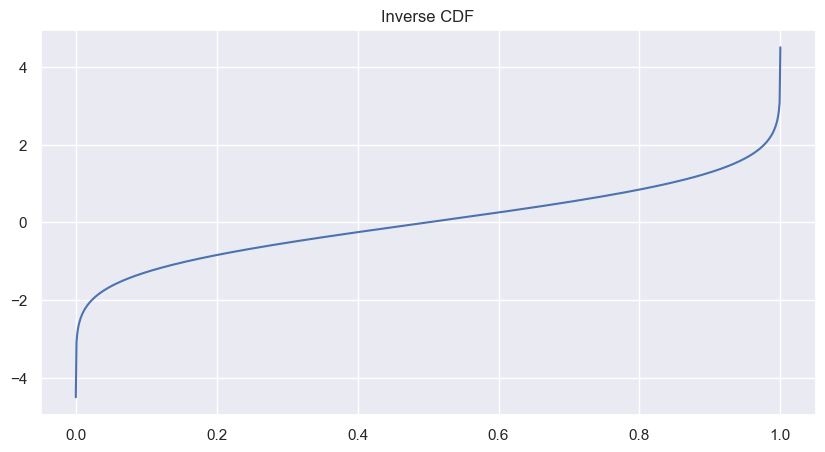

In [14]:
integral_values = np.linspace(0, 1, 1000)
inverse_cdf = np.zeros(1000)

for i in range(1000):
    inverse_cdf[i] = compute_inverse_cdf(integral_values[i])

ax = sns.lineplot(
    x = integral_values, 
    y = inverse_cdf,
)

ax.set(
    title = "Inverse CDF"
)

plt.show()

## <center> Density Functions </center> 

In [15]:
@jit(nopython = True)
def f(x):
    """
    
    """
    
    if x < 0 or x > 1.0:
        return 0
    elif x >= 0 and x < 0.2:
        return 10 * x
    elif x >= 0.2:
        return 2 - 2.5 * (x - 0.2)
    
    return 0

In [16]:
@jit(nopython = True)
def g(x):
    """
    
    """
    
    if x < 0 or x > 1.0:
        return 0
    elif x >= 0 and x < 0.5:
        return 4 * x
    elif x >= 0.5:
        return 2 - 4 * (x - 0.5)

    return 0

In [17]:
x = np.linspace(-1, 2, 1000)

fx = np.copy(x)
for i in range(len(x)):
    fx[i] = f(x[i])

fx_cdf = simpsons_rule(fx, x)

gx = np.copy(x)
for i in range(len(x)):
    gx[i] = g(x[i])
    
gx_cdf = simpsons_rule(gx, x)

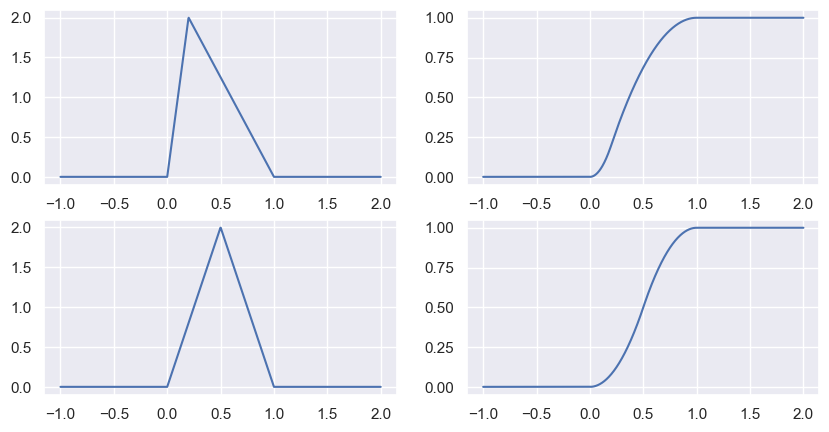

In [18]:
fig, axes = plt.subplots(2, 2)

sns.lineplot(
    x = x,
    y = fx,
    ax = axes[0, 0],
)

sns.lineplot(
    x = x,
    y = fx_cdf,
    ax = axes[0, 1],
)

sns.lineplot(
    x = x,
    y = gx,
    ax = axes[1, 0],
)

sns.lineplot(
    x = x,
    y = gx_cdf,
    ax = axes[1, 1],
)

plt.show()

## <center> Compute Copula </center> 

In [19]:
@jit(nopython = True, parallel = True)
def compute_copula():
    """
    
    """
    
    x, y = compute_cholesky_decomposition(p = 0.9)
    N = len(x)
    
    x1 = np.zeros(N)
    y1 = np.zeros(N) 
    
    for i in prange(N):
        
        interval = np.linspace(-6, x[i], 1000)
        tmp_fx = gaussian_distribution(interval)
        integral = simpsons_rule(tmp_fx, interval)[-1]
        x1[i] = compute_inverse(f, integral)
        
        interval = np.linspace(-6, y[i], 1000)
        tmp_gx = gaussian_distribution(interval)
        integral = simpsons_rule(tmp_gx, interval)[-1]
        y1[i] = compute_inverse(g, integral)
            
    return x1, y1

In [20]:
x1, y1 = compute_copula()

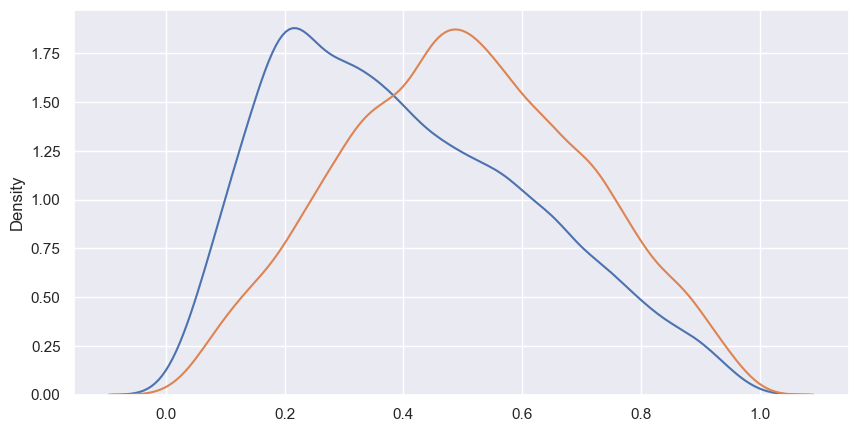

In [21]:
ax = sns.kdeplot(
    x1,
    label = "f(x)",
)

sns.kdeplot(
    y1,
    label = "g(x)",
)

plt.show()

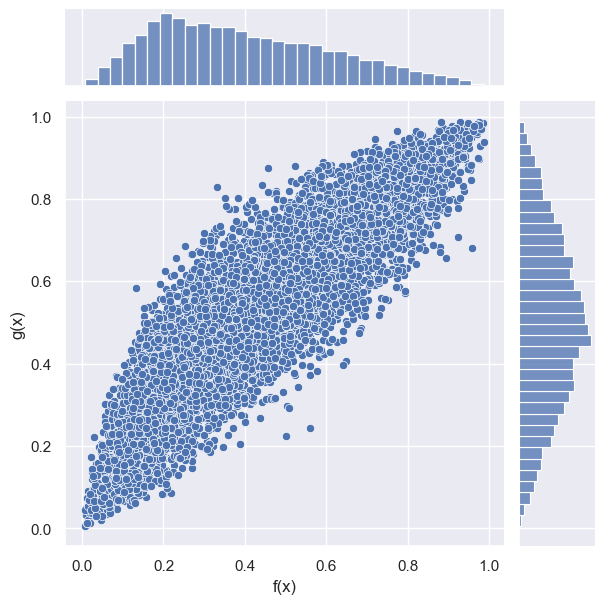

In [22]:
ax = sns.jointplot(
    x = x1, 
    y = y1,
)

ax.set_axis_labels('f(x)', 'g(x)')

plt.show()